In [1]:
import os
import sys
import time
import pickle

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import wandb

In [2]:
from torchmetrics import Accuracy

In [3]:
root_path = os.path.join(os.getcwd().split('cbo-in-tensorflow')[0], 'cbo-in-tensorflow')

sys.path.append(root_path)

In [4]:
from src.datasets import load_mnist_dataloaders
from src.torch.models import *
from src.torch import Optimizer, Loss

In [5]:
IMAGES_FOLDER = os.path.join(os.getcwd(), 'plots')

os.makedirs(IMAGES_FOLDER, exist_ok=True)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')

In [7]:
epochs = 25
batch_size = 60
particles_batch_size = 10

n_particles = 100
alpha = 50
sigma = 0.4 ** 0.5
l = 1
dt = 0.1
anisotropic = True
eps = 1e-2

partial_update = False

use_multiprocessing=False
n_processes = 4

In [8]:
train_dataloader, test_dataloader = load_mnist_dataloaders(train_batch_size=batch_size,
                                                           test_batch_size=batch_size)

In [9]:
n_batches = len(train_dataloader)

In [10]:
eval_freq = 100

In [11]:
def evaluate(model, X_, y_):
    with torch.no_grad():
        outputs = model(X_)
        y_pred = torch.argmax(outputs, dim=1)
        loss = loss_fn(outputs, y_)
        acc = accuracy(y_pred.cpu(), y_.cpu())
    return loss, acc

def log(loss, acc, epoch, stage='train', shift_norm=None):
    wandb.log({
        f'{stage}_loss': loss,
        f'{stage}_acc': acc,
        'epoch': epoch,
        f'{stage}_shift_norm': shift_norm,
    })

In [16]:
results = {}

In [17]:
for eps in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0]:
    model = SmallMLP().to(device)
    optimizer = Optimizer(model, n_particles=n_particles, alpha=alpha, sigma=sigma,
                          l=l, dt=dt, anisotropic=anisotropic, eps=eps, partial_update=partial_update,
                          use_multiprocessing=use_multiprocessing, n_processes=n_processes,
                          particles_batch_size=particles_batch_size, device=device)
    loss_fn = Loss(F.nll_loss, optimizer)
    accuracy = Accuracy()

    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    for epoch in range(epochs):
        epoch_train_accuracies = []
        epoch_train_losses = []
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            train_loss, train_acc = evaluate(model, X, y)
            epoch_train_accuracies.append(train_acc)
            epoch_train_losses.append(train_loss.cpu())

            optimizer.zero_grad()
            loss_fn.backward(X, y, backward_gradients=False)
            optimizer.step()

            if batch % eval_freq == 0 or batch == n_batches - 1:
                with torch.no_grad():
                    losses = []
                    accuracies = []
                    for X_test, y_test in test_dataloader:
                        X_test, y_test = X_test.to(device), y_test.to(device)
                        loss, acc = evaluate(model, X_test, y_test)
                        losses.append(loss.cpu())
                        accuracies.append(acc.cpu())
                    val_loss, val_acc = np.mean(losses), np.mean(accuracies)
                    if batch == n_batches - 1:
                        val_accuracies.append(val_acc)
                        val_losses.append(val_loss)

                print(f'Epoch: {epoch + 1:2}/{epochs}, batch: {batch + 1:4}/{n_batches}, train loss: {train_loss:8.3f}, train acc: {train_acc:8.3f}, val loss: {val_loss:8.3f}, val acc: {val_acc:8.3f}',
                      end='\r')
        train_accuracies.append(np.mean(epoch_train_accuracies))
        train_losses.append(np.mean(epoch_train_losses))
    
    results[eps] = (np.array(train_accuracies), np.array(train_losses),
                    np.array(val_accuracies), np.array(val_losses))

In [18]:
with open('results_additional_random_shift.pkl', 'wb') as pkl_file:
    pickle.dump(results, pkl_file)

In [29]:
with open('results_additional_random_shift.pkl', 'rb') as pkl_file:
    results = pickle.load(pkl_file)

In [30]:
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['font.size'] = 25
plt.rcParams['text.usetex'] = True

<Figure size 1440x1440 with 0 Axes>

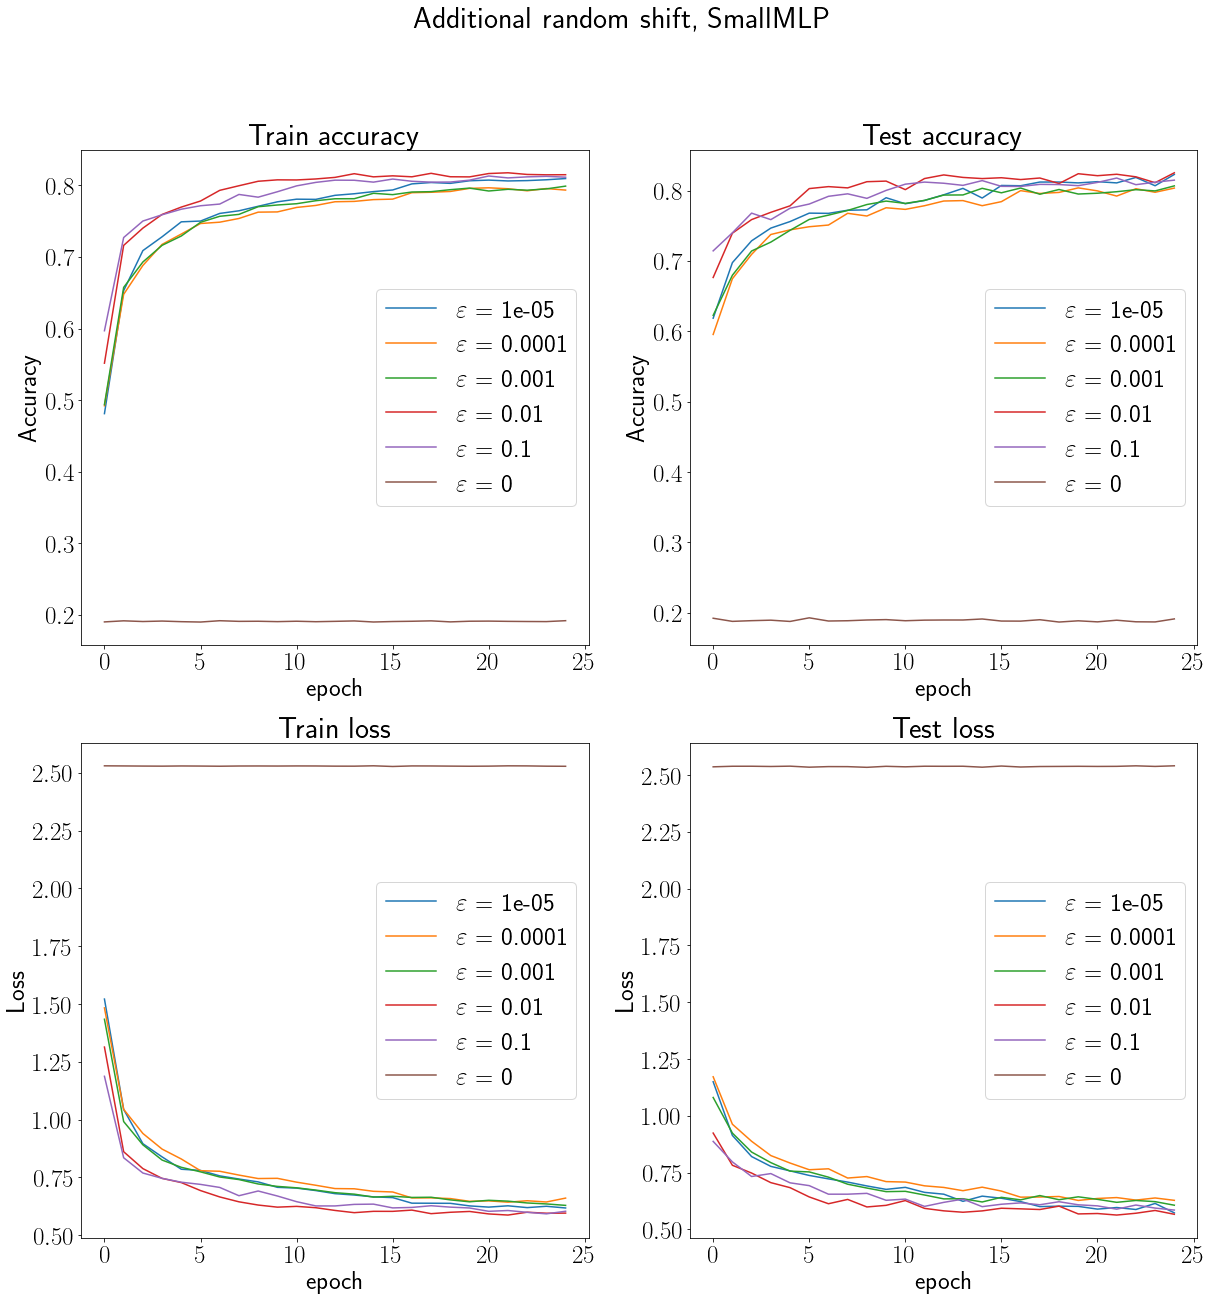

In [31]:
epochs_range = np.arange(epochs)

plt.clf()

fig, axs = plt.subplots(2, 2)
plt.suptitle('Additional random shift, SmallMLP')

for ax in [axs[0][0], axs[0][1]]:
    ax.set_xlabel('epoch')
    ax.set_ylabel('Accuracy')

for ax in [axs[1][0], axs[1][1]]:
    ax.set_xlabel('epoch')
    ax.set_ylabel('Loss')
    
axs[0][0].set_title('Train accuracy')
axs[0][1].set_title('Test accuracy')
axs[1][0].set_title('Train loss')
axs[1][1].set_title('Test loss')

for eps, (train_acc, train_loss, test_acc, test_loss) in results.items():
    label = fr'$\varepsilon$ = {eps}'
    axs[0][0].plot(epochs_range, train_acc, label=label)
    axs[0][1].plot(epochs_range, test_acc, label=label)
    axs[1][0].plot(epochs_range, train_loss, label=label)
    axs[1][1].plot(epochs_range, test_loss, label=label)

for ax in [axs[0][0], axs[0][1], axs[1][0], axs[1][1]]:
    ax.legend()

plt.savefig(os.path.join(IMAGES_FOLDER, 'additional_random_shift_small_mlp.png'))
plt.show()

In [32]:
model = LeNet5().to(device)
optimizer = Optimizer(model, n_particles=n_particles, alpha=alpha, sigma=sigma,
                      l=l, dt=dt, anisotropic=anisotropic, eps=1e-5, partial_update=partial_update,
                      use_multiprocessing=use_multiprocessing, n_processes=n_processes,
                      particles_batch_size=particles_batch_size, device=device)
loss_fn = Loss(F.nll_loss, optimizer)
accuracy = Accuracy()

train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(epochs):
    epoch_train_accuracies = []
    epoch_train_losses = []
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        train_loss, train_acc = evaluate(model, X, y)
        epoch_train_accuracies.append(train_acc)
        epoch_train_losses.append(train_loss.cpu())

        optimizer.zero_grad()
        loss_fn.backward(X, y, backward_gradients=False)
        optimizer.step()

        if batch % eval_freq == 0 or batch == n_batches - 1:
            with torch.no_grad():
                losses = []
                accuracies = []
                for X_test, y_test in test_dataloader:
                    X_test, y_test = X_test.to(device), y_test.to(device)
                    loss, acc = evaluate(model, X_test, y_test)
                    losses.append(loss.cpu())
                    accuracies.append(acc.cpu())
                val_loss, val_acc = np.mean(losses), np.mean(accuracies)
                if batch == n_batches - 1:
                    val_accuracies.append(val_acc)
                    val_losses.append(val_loss)

            print(f'Epoch: {epoch + 1:2}/{epochs}, batch: {batch + 1:4}/{n_batches}, train loss: {train_loss:8.3f}, train acc: {train_acc:8.3f}, val loss: {val_loss:8.3f}, val acc: {val_acc:8.3f}',
                  end='\r')
    train_accuracies.append(np.mean(epoch_train_accuracies))
    train_losses.append(np.mean(epoch_train_losses))

with open('results_additional_random_shift_lenet5.pkl', 'wb') as pkl_file:
    pickle.dump((np.array(train_accuracies), np.array(train_losses),
                 np.array(val_accuracies), np.array(val_losses)), pkl_file)

/home/itukh/anaconda3/envs/py39/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


KeyboardInterrupt: 

In [13]:
with open('results_additional_random_shift_lenet5.pkl', 'rb') as pkl_file:
    train_acc, train_loss, test_acc, test_loss = pickle.load(pkl_file)

In [25]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 25
plt.rcParams['text.usetex'] = True

<Figure size 1440x720 with 0 Axes>

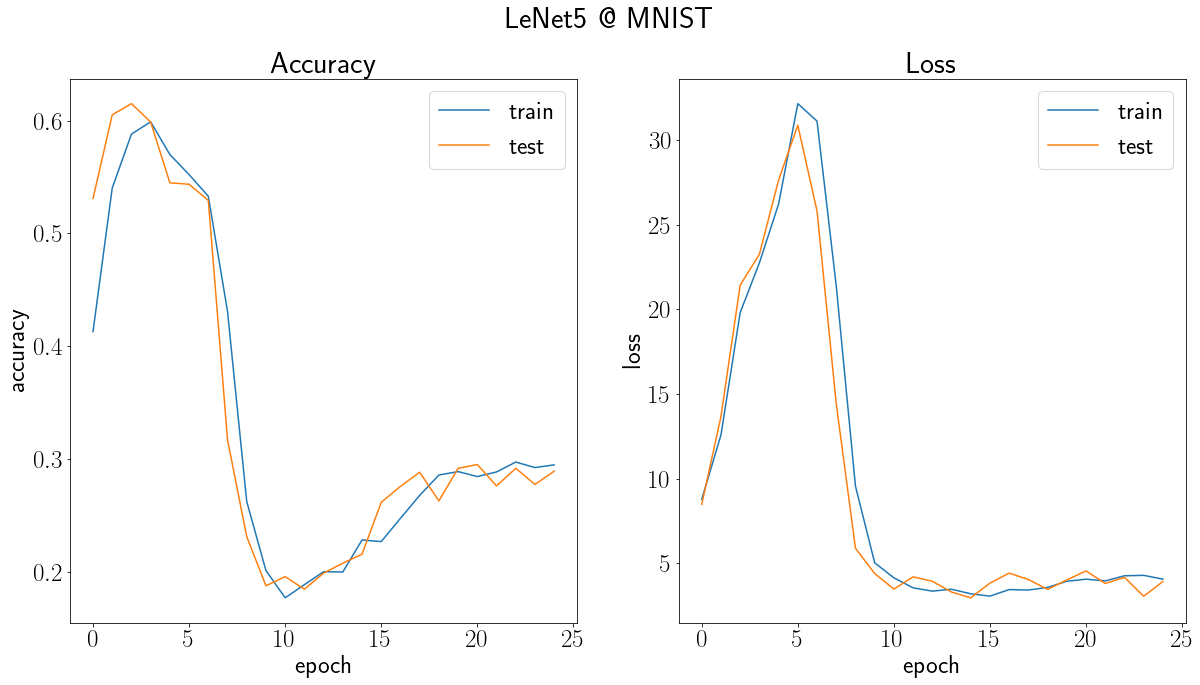

In [26]:
epochs_range = np.arange(epochs)

plt.clf()

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.suptitle('LeNet5 @ MNIST')

ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy')

ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss')

ax1.plot(epochs_range, train_acc, label='train')
ax1.plot(epochs_range, test_acc, label='test')
ax2.plot(epochs_range, train_loss, label='train')
ax2.plot(epochs_range, test_loss, label='test')

ax1.legend()
ax2.legend()

plt.savefig(os.path.join(IMAGES_FOLDER, 'training_lenet5.png'))
plt.show()